In [1]:
import numpy as np
import pandas as pd
import tabulate
import matplotlib.pyplot as plt

plt.rc('font', family='arial')
plt.rc('pdf', fonttype = 42)
plt.rc('ps', fonttype = 42)

In [2]:
cd ..

d:\research\FedImpute


d:\research\FedImpute\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Load Data

In [3]:
%load_ext autoreload
%autoreload 2

from fedimpute.data_prep import load_data, display_data
data, data_config = load_data("codrna")
display_data(data)
print("Data Dimensions: ", data.shape)
print("Data Config:\n", data_config)

+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|   X1   |   X2   |   X3   |   X4   |   X5   |   X6   |   X7   |   X8   |   y    |
|--------+--------+--------+--------+--------+--------+--------+--------+--------|
| 0.7554 | 0.1364 | 0.0352 | 0.4132 | 0.6937 | 0.1591 | 0.3329 | 0.7154 | 1.0000 |
| 0.7334 | 0.7879 | 0.3819 | 0.3693 | 0.5619 | 0.4830 | 0.4351 | 0.5160 | 0.0000 |
| 0.7752 | 0.1364 | 0.1761 | 0.3290 | 0.7410 | 0.4259 | 0.4644 | 0.5268 | 1.0000 |
| 0.5905 | 0.7424 | 0.2720 | 0.2898 | 0.6920 | 0.3205 | 0.4019 | 0.6290 | 1.0000 |
| 0.7366 | 0.1212 | 0.2465 | 0.3290 | 0.7410 | 0.3249 | 0.5086 | 0.5631 | 1.0000 |
+--------+--------+--------+--------+--------+--------+--------+--------+--------+
Data Dimensions:  (5000, 9)
Data Config:
 {'target': 'y', 'task_type': 'classification', 'natural_partition': False}


# Scenario Simulation

## Basic Usage

In [4]:
%load_ext autoreload
%autoreload 2
from fedimpute.scenario import ScenarioBuilder

scenario_builder = ScenarioBuilder()
scenario_data = scenario_builder.create_simulated_scenario(
    data, data_config, num_clients = 4, dp_strategy='iid-even', ms_scenario='mnar-heter'
)
print('Results Structure (Dict Keys):')
print(list(scenario_data.keys()))
scenario_builder.summarize_scenario()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Missing data simulation...
Results Structure (Dict Keys):
['clients_train_data', 'clients_test_data', 'clients_train_data_ms', 'clients_seeds', 'global_test_data', 'data_config', 'stats']
Scenario Summary
Total clients: 4
Global Test Data: (500, 9)
Missing Mechanism Category: MNAR (Self Masking Logit)
Clients Data Summary:
     Train     Test      Miss     MS Ratio    MS Feature    Seed
--  --------  -------  --------  ----------  ------------  ------
C1  (1125,9)  (113,9)  (1125,8)     0.47         8/8        6077
C2  (1125,9)  (113,9)  (1125,8)     0.51         8/8        577
C3  (1125,9)  (113,9)  (1125,8)     0.46         8/8        7231
C4  (1125,9)  (113,9)  (1125,8)     0.47         8/8        5504



## Exploring Scenario


### Data Heterogeneity


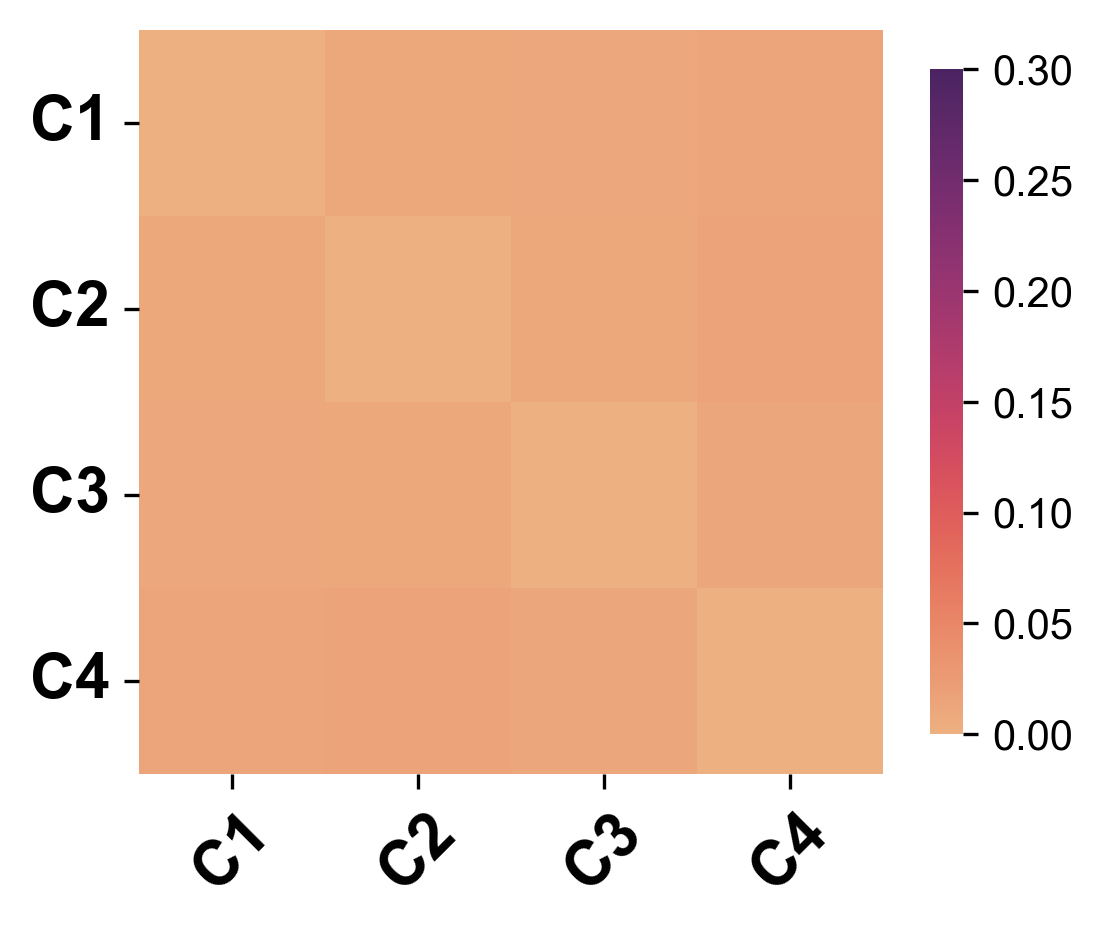

In [5]:
scenario_builder.visualize_data_heterogeneity(
    client_ids=[0, 1, 2, 3], 
    distance_method='swd',
    pca_col_threshold=20,
    fontsize=18,
    title=False,
    save_path='./plots/data_heterogeneity.svg'
)

### Missing Data Inspection


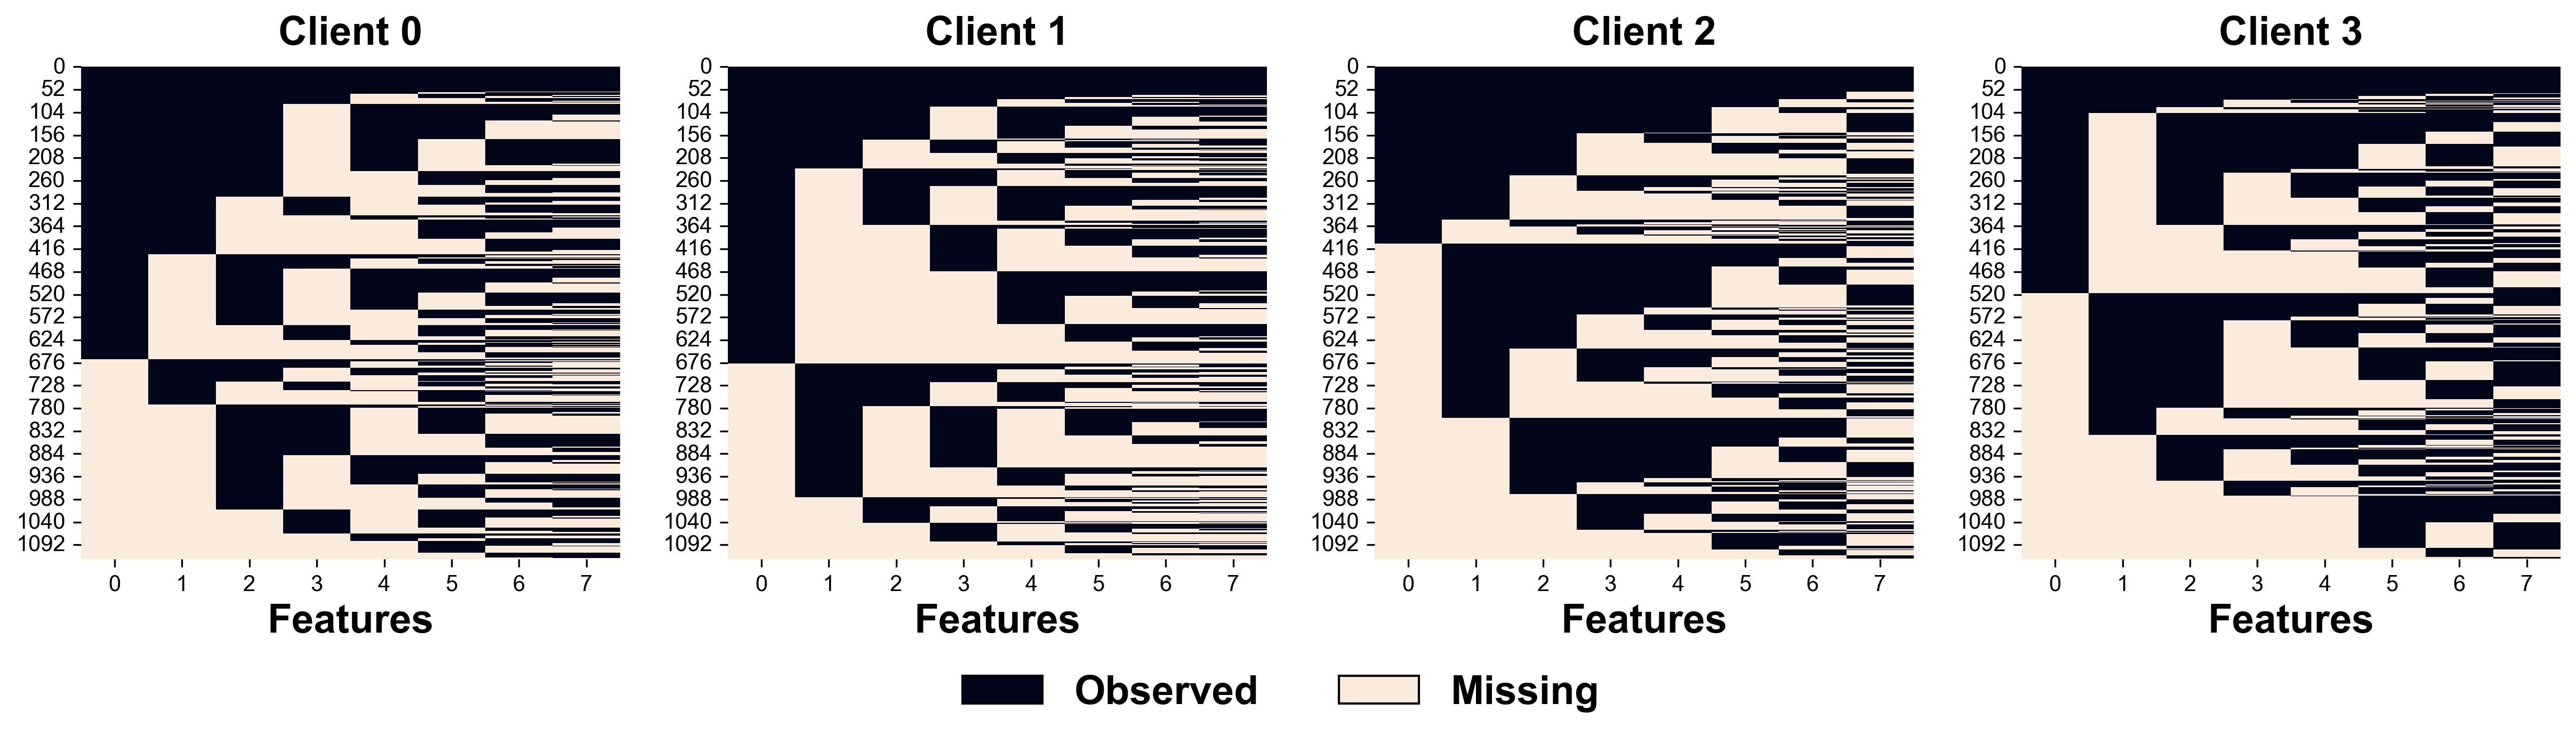

In [6]:
scenario_builder.visualize_missing_pattern(client_ids=[0, 1, 2, 3], save_path='./plots/ms_pattern.pdf')

In [7]:
scenario_builder.visualize_missing_distribution(
    client_ids = [0, 1], feature_ids = [0, 1, 2, 3, 4],
    stat = 'proportion', bins = 20, kde=True,
    save_path='./plots/ms_distribution.pdf'
)

# Running Federated Imputation

## Basic Usage

In [8]:
%load_ext autoreload
%autoreload 2
from fedimpute.execution_environment import FedImputeEnv

env = FedImputeEnv(debug_mode=False)
env.configuration(imputer = 'mice', fed_strategy='fedmice')
env.setup_from_scenario_builder(scenario_builder = scenario_builder, verbose=1)
env.show_env_info()
env.run_fed_imputation()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setting up clients...
Setting up server...
Setting up workflow...
Environment setup complete.
Environment Information:
Workflow: ICE (Imputation via Chain Equation)
Clients:
 - Client 0: imputer: mice, fed-strategy: fedmice
 - Client 1: imputer: mice, fed-strategy: fedmice
 - Client 2: imputer: mice, fed-strategy: fedmice
 - Client 3: imputer: mice, fed-strategy: fedmice
Server: fed-strategy: fedmice



ICE Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

## Monitoring Imputation Progress


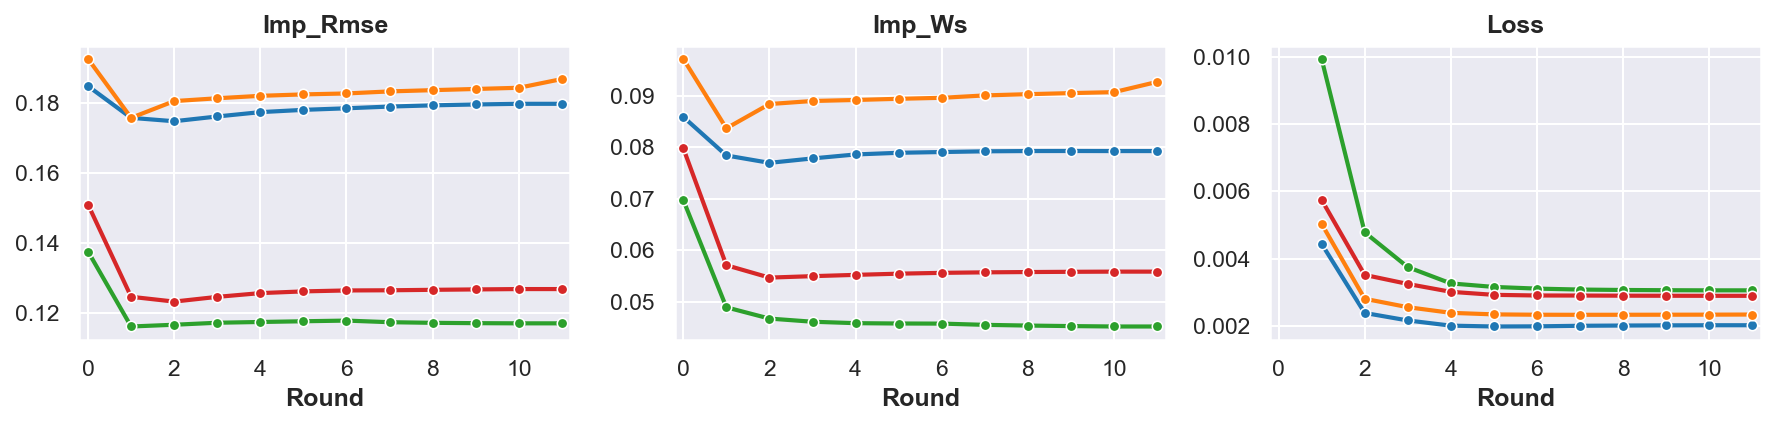

In [9]:
env.tracker.visualize_imputation_process()

# Evaluation

### Imputation Quality

In [10]:
%load_ext autoreload
%autoreload 2
from fedimpute.evaluation import Evaluator

X_trains = env.get_data(client_ids='all', data_type = 'train')
X_train_imps = env.get_data(client_ids='all', data_type = 'train_imp')
X_train_masks = env.get_data(client_ids='all', data_type = 'train_mask')

evaluator = Evaluator()
ret = evaluator.evaluate_imp_quality(
    X_train_imps = X_train_imps,
    X_train_origins = X_trains,
    X_train_masks = X_train_masks,
    metrics = ['rmse', 'nrmse', 'sliced-ws']
)
evaluator.show_imp_results()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Imputation Quality
               rmse       nrmse      sliced-ws
----------  ----------  ----------  -----------
 Client 1     0.180       0.501        0.079
 Client 2     0.187       0.541        0.093
 Client 3     0.117       0.324        0.045
 Client 4     0.127       0.355        0.056
----------  ----------  ----------  ----------
 Average      0.152       0.430        0.068
   Std        0.031       0.092        0.019


Evaluating TSNE for Client 1 ...
Evaluating TSNE for Client 2 ...
Evaluating TSNE for Client 3 ...
Evaluating TSNE for Client 4 ...


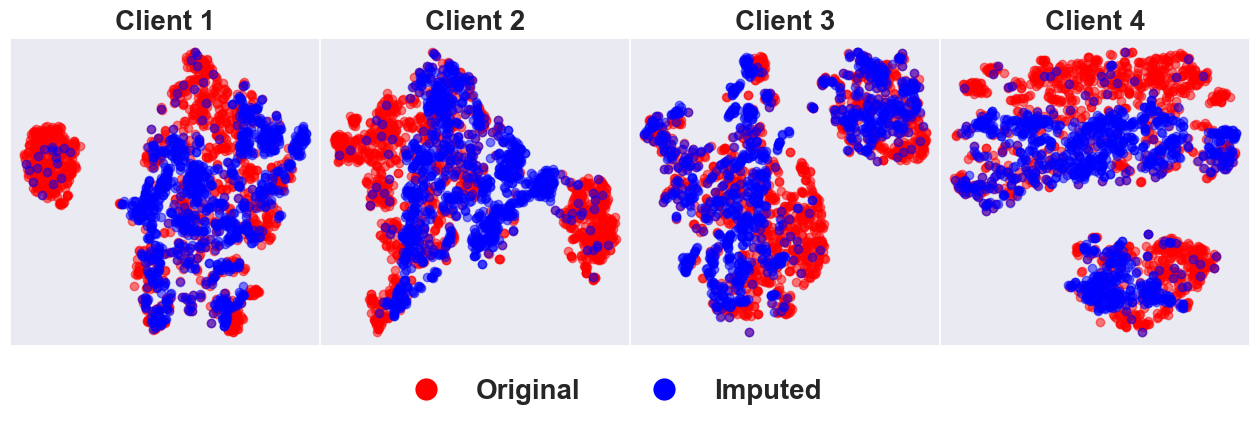

In [21]:
X_trains = env.get_data(client_ids='all', data_type = 'train')
X_train_imps = env.get_data(client_ids='all', data_type = 'train_imp')

evaluator.tsne_visualization(
    X_imps = X_train_imps,
    X_origins = X_trains,
    seed = 0
)

### Local Prediction

In [11]:
X_train_imps, y_trains = env.get_data(client_ids='all', data_type = 'train_imp', include_y=True)
X_tests, y_tests = env.get_data(client_ids='all', data_type = 'test', include_y=True)
X_global_test, y_global_test = env.get_data(data_type = 'global_test', include_y = True)
data_config = env.get_data(data_type = 'config')

In [19]:
ret = evaluator.run_local_prediction(
    X_train_imps = X_train_imps,
    y_trains = y_trains,
    X_tests = X_tests,
    y_tests = y_tests,
    data_config = data_config,
    model = 'lr',
    seed= 0
)
evaluator.show_local_prediction_results()

Clients:   0%|          | 0/4 [00:00<?, ?it/s]

Downstream Prediction (Local)
             accuracy       f1         auc         prc
----------  ----------  ----------  ----------  ----------
 Client 1     0.903       0.871       0.991       0.981
 Client 2     0.929       0.889       0.977       0.959
 Client 3     0.850       0.809       0.948       0.907
 Client 4     0.832       0.791       0.973       0.969
----------  ----------  ----------  ----------  ----------
 Average      0.878       0.840       0.972       0.954
   Std        0.039       0.041       0.015       0.028


### Federated Prediction

In [21]:
ret = evaluator.run_fed_prediction(
    X_train_imps = X_train_imps,
    y_trains = y_trains,
    X_tests = X_tests,
    y_tests = y_tests,
    X_test_global = X_global_test,
    y_test_global = y_global_test,
    data_config = data_config,
    model_name = 'rf',
    seed= 0
)

evaluator.show_fed_prediction_results()

(900, 8) (900,)
Downstream Prediction (Fed)
 Personalized    accuracy       f1         auc         prc
--------------  ----------  ----------  ----------  ----------
   Client 1       0.956       0.933       0.986       0.947
   Client 2       0.956       0.932       0.994       0.986
   Client 3       0.956       0.933       0.994       0.987
   Client 4       0.876       0.806       0.970       0.946
  ----------    ----------  ----------  ----------  ----------
    Global        0.910       0.856       0.953       0.902


### All In One

In [34]:
%load_ext autoreload
%autoreload 2
from fedimpute.evaluation import Evaluator

evaluator = Evaluator()
ret = evaluator.evaluate_all(
    env, metrics = ['imp_quality', 'pred_downstream_local', 'pred_downstream_fed']
)
evaluator.show_results_all()

Evaluating imputation quality...
Imputation quality evaluation completed.
Evaluating downstream prediction...


Clients:   0%|          | 0/4 [00:00<?, ?it/s]

Early stopping at epoch 593
Early stopping at epoch 287
Early stopping at epoch 583
Early stopping at epoch 360
Downstream prediction evaluation completed.
Evaluating federated downstream prediction...


Global Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 - average loss: 0.6716053117724026
Epoch 10 - average loss: 0.5709273157750859
Epoch 20 - average loss: 0.48411076998009406
Epoch 30 - average loss: 0.4436344894416192
Epoch 40 - average loss: 0.43356676005265293
Epoch 50 - average loss: 0.4266376635607551
Epoch 60 - average loss: 0.4221082873204175
Early stopping at epoch 65
Epoch 70 - average loss: 0.40617619396424764
Early stopping at epoch 71
Early stopping at epoch 74
Epoch 80 - average loss: 0.3788260501973769
Early stopping at epoch 81
Early stopping at epoch 100
Early stopping at epoch 121
Early stopping at epoch 125
Federated downstream prediction evaluation completed.
Evaluation completed.


imp_quality                     pred_downstream_local                      \
         rmse     nrmse sliced-ws              accuracy        f1       auc   
0    0.172028  0.479522  0.075509              0.787611  0.636364  0.860953   
1    0.184269  0.533933  0.090226              0.893805  0.823529  0.952703   
2    0.119754  0.331969  0.047390              0.929204  0.894737  0.975818   
3    0.128211  0.359113  0.057849              0.752212  0.481481  0.854196   

              pred_downstream_fed                                   \
        prc personalized_accuracy personalized_f1 personalized_auc   
0  0.741470              0.884956        0.831169         0.958037   
1  0.934722              0.920354        0.883117         0.981508   
2  0.969489              0.884956        0.835443         0.975462   
3  0.760059              0.867257        0.819277         0.972617   

                                                                    
  personalized_prc global_accuracy global_f1 global_auc global_prc  
0         0.900117           0.906   0.86217   0.968807    0.94098  
1         0.956229           0.906   0.86217   0.968807    0.94098  
2         0.951035           0.906   0.86217   0.968807    0.94098  
3         0.961279           0.906   0.86217   0.968807    0.94098

### Export Evaluation Results in Different Format

In [26]:
evaluator.export_results(format = 'dataframe')

imp_quality                     pred_downstream_local                      \
         rmse     nrmse sliced-ws              accuracy        f1       auc   
0    0.172028  0.479522  0.075509              0.787611  0.636364  0.860953   
1    0.184269  0.533933  0.090226              0.893805  0.823529  0.952703   
2    0.119754  0.331969  0.047390              0.929204  0.894737  0.975818   
3    0.128211  0.359113  0.057849              0.752212  0.481481  0.854196   

              pred_downstream_fed                                   \
        prc personalized_accuracy personalized_f1 personalized_auc   
0  0.741470              0.884956        0.831169         0.958037   
1  0.934722              0.920354        0.883117         0.981508   
2  0.969489              0.884956        0.835443         0.975462   
3  0.760059              0.867257        0.819277         0.972617   

                                                                    
  personalized_prc global_accuracy global_f1 global_auc global_prc  
0         0.900117           0.906   0.86217   0.968807    0.94098  
1         0.956229           0.906   0.86217   0.968807    0.94098  
2         0.951035           0.906   0.86217   0.968807    0.94098  
3         0.961279           0.906   0.86217   0.968807    0.94098

In [29]:
ret = evaluator.export_results(format = 'dict-dataframe')
ret['imp_quality']

,rmse,nrmse,sliced-ws
0,0.172028,0.479522,0.075509
1,0.184269,0.533933,0.090226
2,0.119754,0.331969,0.047390
3,0.128211,0.359113,0.057849


In [32]:
ret = evaluator.export_results(format = 'dict-dataframe')
ret['pred_downstream_fed']

,personalized_accuracy,personalized_f1,personalized_auc,personalized_prc,global_accuracy,global_f1,global_auc,global_prc
0,0.884956,0.831169,0.958037,0.900117,0.906,0.86217,0.968807,0.94098
1,0.920354,0.883117,0.981508,0.956229,0.906,0.86217,0.968807,0.94098
2,0.884956,0.835443,0.975462,0.951035,0.906,0.86217,0.968807,0.94098
3,0.867257,0.819277,0.972617,0.961279,0.906,0.86217,0.968807,0.94098


# regression analysis

In [31]:
X_trains, y_trains = env.get_data(client_ids='all', data_type = 'train', include_y=True)
data_config = env.get_data(data_type = 'config')
data_config['task_type'] = 'classification'

ret = evaluator.run_local_regression_analysis(
    X_train_imps = X_train_imps,
    y_trains = y_trains,
    data_config = data_config
)

evaluator.show_local_regression_results(client_idx = 0)

                  Local Logit Regression Results (client 1)                   
Dep. Variable:                      y   No. Observations:                 1125
Model:                          Logit   Df Residuals:                     1116
Method:                           MLE   Df Model:                            8
Date:                Sat, 19 Apr 2025   Pseudo R-squ.:                  0.2610
Time:                        19:24:47   Log-Likelihood:                -523.90
converged:                       True   LL-Null:                       -708.95
Covariance Type:            nonrobust   LLR p-value:                 4.655e-75
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.9509      4.894     10.002      0.000      39.358      58.543
X1           -87.4838      8.156    -10.726      0.000    -103.469     -71.499
X2           -19.3553      2.524     -7.668      0.0

In [33]:
X_trains, y_trains = env.get_data(client_ids='all', data_type = 'train', include_y=True)
data_config = env.get_data(data_type = 'config')
data_config['task_type'] = 'classification'

evaluator.run_fed_regression_analysis(
    X_train_imps = X_train_imps,
    y_trains = y_trains,
    data_config = data_config
)
evaluator.show_fed_regression_results()

                      Federated Logit Regression Result                       
Dep. Variable:                      y   No. Observations:                 4500
Model:                          Logit   Df Residuals:                     4491
Method:                           MLE   Df Model:                            8
Date:                Sat, 19 Apr 2025   Pseudo R-squ.:                  0.2459
Time:                        19:25:23   Log-Likelihood:                -2138.6
converged:                       True   LL-Null:                       -2835.8
Covariance Type:            nonrobust   LLR p-value:                9.046e-296
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.8802      0.132    234.469      0.000      30.622      31.138
X1           -64.6134      0.238   -271.819      0.000     -65.079     -64.148
X2           -16.5444      0.066   -251.716      0.0

# Logit

In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

X, y = data.iloc[:, :-1], data.iloc[:, -1]
# Add constant for intercept
X_with_const = sm.add_constant(X)

# Fit logistic regression model
logit_model = sm.Logit(y, X_with_const)
result = logit_model.fit()

# Print summary
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.139287
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4991
Method:                           MLE   Df Model:                            8
Date:                Sat, 19 Apr 2025   Pseudo R-squ.:                  0.7789
Time:                        18:31:28   Log-Likelihood:                -696.43
converged:                       True   LL-Null:                       -3150.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.6951      2.685     22.231      0.000      54.432      64.958
X1           -89.4767      3.

In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

X, y = data.iloc[:, :-1], data.iloc[:, -1]
# Add constant for intercept
X_with_const = sm.add_constant(X)

# Fit linear regression model
linear_model = sm.OLS(y, X_with_const)
result = linear_model.fit()

# Print summary
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     1304.
Date:                Sat, 19 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:18:12   Log-Likelihood:                -478.88
No. Observations:                5000   AIC:                             975.8
Df Residuals:                    4991   BIC:                             1034.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7116      0.105     44.899      0.0

In [31]:
result.cov_type

'nonrobust'

In [62]:
# Get the fitted parameters (coefficients)
params = result.params
print("Model Parameters (Coefficients):")
print(params)
print(type(params))


Model Parameters (Coefficients):
const    59.695071
X1      -89.476667
X2      -16.909306
X3        8.871990
X4        8.489870
X5       -0.635150
X6       12.138465
X7        7.429060
X8        1.636189
dtype: float64
<class 'pandas.core.series.Series'>


In [93]:
# Call the parent class's fit method using super()
bnryfit = super(sm.Logit, logit_model).fit(
    start_params=None,
    method='newton',
    maxiter=35,
    full_output=1,
    disp=1,
    callback=None,
)

    # discretefit = LogitResults(self, bnryfit)
    # return BinaryResultsWrapper(discretefit)


Optimization terminated successfully.
         Current function value: 0.139287
         Iterations 9


In [107]:
from statsmodels.base.model import LikelihoodModelResults
from statsmodels.discrete.discrete_model import LogitResults, BinaryResultsWrapper, Logit

mlefit = LikelihoodModelResults(logit_model, bnryfit.params, bnryfit.normalized_cov_params, scale=1.)
mlefit.mle_retvals = {'converged': True}
mlefit.mle_settings = {'optimizer': 'newton'}
discretefit = LogitResults(logit_model, mlefit)
discretefit_wrapper = BinaryResultsWrapper(discretefit)
print(discretefit_wrapper.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4991
Method:                           MLE   Df Model:                            8
Date:                Sat, 19 Apr 2025   Pseudo R-squ.:                  0.7789
Time:                        17:20:25   Log-Likelihood:                -696.43
converged:                       True   LL-Null:                       -3150.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.6951      2.685     22.231      0.000      54.432      64.958
X1           -89.4767      3.027    -29.562      0.000     -95.409     -83.544
X2           -16.9093      0.638    -26.489      0.0

In [117]:
summary = discretefit_wrapper.summary()
summary.tables[0].title = 'Federated Logit Regression Result'
print(summary)


                      Federated Logit Regression Result                       
Dep. Variable:                      y   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4991
Method:                           MLE   Df Model:                            8
Date:                Sat, 19 Apr 2025   Pseudo R-squ.:                  0.7789
Time:                        17:24:26   Log-Likelihood:                -696.43
converged:                       True   LL-Null:                       -3150.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.6951      2.685     22.231      0.000      54.432      64.958
X1           -89.4767      3.027    -29.562      0.000     -95.409     -83.544
X2           -16.9093      0.638    -26.489      0.0

In [123]:
import numpy as np
from scipy.special import expit  # sigmoid function

# Convert continuous y to binary for logistic regression
X, y = data.iloc[:, :-1], data.iloc[:, -1]
y_binary = y.astype(int)

# Add constant term to X
X_with_const = np.column_stack((np.ones(X.shape[0]), X))

def logistic_regression_newton_raphson(X, y, max_iter=100, tol=1e-6):
    """
    Implement logistic regression using Newton-Raphson method from scratch
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Training data
    y : array-like, shape (n_samples,)
        Target values (binary)
    max_iter : int, optional (default=100)
        Maximum number of iterations
    tol : float, optional (default=1e-6)
        Tolerance for stopping criterion
    
    Returns:
    --------
    beta : array, shape (n_features,)
        Coefficients
    ll_history : list
        Log-likelihood history
    """
    n_samples, n_features = X.shape
    
    # Initialize parameters
    beta = np.zeros(n_features)
    ll_history = []
    
    for iteration in range(max_iter):
        # Calculate predicted probabilities
        z = X.dot(beta)
        p = expit(z)
        
        # Calculate log-likelihood
        ll = np.sum(y * np.log(p + 1e-10) + (1 - y) * np.log(1 - p + 1e-10))
        ll_history.append(ll)
        
        # Calculate gradient (first derivative)
        gradient = X.T.dot(y - p)
        
        # Calculate Hessian (second derivative)
        W = np.diag(p * (1 - p))
        hessian = -X.T.dot(W).dot(X)
        
        # Update parameters using Newton-Raphson step
        try:
            beta_update = np.linalg.solve(hessian, gradient)
        except np.linalg.LinAlgError:
            # Use pseudo-inverse if hessian is not invertible
            beta_update = np.linalg.pinv(hessian).dot(gradient)
        
        beta -= beta_update
        
        # Check convergence
        if np.linalg.norm(beta_update) < tol:
            break
    
    return beta, hessian, ll_history

# Fit the model using our Newton-Raphson implementation
beta, hessian, ll_history = logistic_regression_newton_raphson(X_with_const, y_binary)
normalized_cov_params = np.linalg.inv(-hessian)/X_with_const.shape[0]

from statsmodels.base.model import LikelihoodModelResults
from statsmodels.discrete.discrete_model import LogitResults, BinaryResultsWrapper, Logit

mlefit = LikelihoodModelResults(logit_model, beta, normalized_cov_params, scale=1.)
mlefit.mle_retvals = {'converged': True}
mlefit.mle_settings = {'optimizer': 'newton'}
discretefit = LogitResults(logit_model, mlefit)
discretefit_wrapper = BinaryResultsWrapper(discretefit)
print(discretefit_wrapper.summary())


# Print the results
# print("Logistic Regression with Newton-Raphson Method (from scratch)")
# print("Coefficients:")
# print(beta)
# print(f"Final log-likelihood: {ll_history[-1]}")
# print(f"Number of iterations: {len(ll_history)}")

# # Plot the log-likelihood history
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.plot(ll_history)
# plt.title('Log-Likelihood History')
# plt.xlabel('Iteration')
# plt.ylabel('Log-Likelihood')
# plt.grid(True)
# plt.show()

# # Make predictions
# z_pred = X_with_const.dot(beta)
# y_pred_prob = expit(z_pred)
# y_pred = (y_pred_prob > 0.5).astype(int)

# # Calculate accuracy
# accuracy = np.mean(y_pred == y_binary)
# print(f"Accuracy: {accuracy:.4f}")

# # Distributed Newton-Raphson implementation
# def distributed_logistic_regression(X_parts, y_parts, max_iter=100, tol=1e-6):
#     """
#     Distributed logistic regression using Newton-Raphson
    
#     Parameters:
#     -----------
#     X_parts : list of arrays
#         Partitioned feature matrices
#     y_parts : list of arrays
#         Partitioned target vectors
    
#     Returns:
#     --------
#     beta : array
#         Coefficients
#     """
#     # Get dimensions from first partition
#     n_features = X_parts[0].shape[1]
    
#     # Initialize parameters
#     beta = np.zeros(n_features)
    
#     for iteration in range(max_iter):
#         # Initialize aggregated gradient and hessian
#         total_gradient = np.zeros(n_features)
#         total_hessian = np.zeros((n_features, n_features))
        
#         # Process each partition
#         for X_part, y_part in zip(X_parts, y_parts):
#             # Calculate predicted probabilities
#             z = X_part.dot(beta)
#             p = expit(z)
            
#             # Calculate gradient for this partition
#             gradient = X_part.T.dot(y_part - p)
            
#             # Calculate Hessian for this partition
#             W = np.diag(p * (1 - p))
#             hessian = -X_part.T.dot(W).dot(X_part)
            
#             # Aggregate
#             total_gradient += gradient
#             total_hessian += hessian
        
#         # Update parameters using Newton-Raphson step
#         try:
#             beta_update = np.linalg.solve(total_hessian, total_gradient)
#         except np.linalg.LinAlgError:
#             beta_update = np.linalg.pinv(total_hessian).dot(total_gradient)
        
#         beta -= beta_update
        
#         # Check convergence
#         if np.linalg.norm(beta_update) < tol:
#             break
    
#     return beta

# # Split the data into m partitions
# X_parts = list(_exog_gen(X_with_const, m))
# y_parts = list(_endog_gen(y_binary, m))

# # Fit distributed model
# dist_beta = distributed_logistic_regression(X_parts, y_parts)

# # Compare results
# print("\nComparison of coefficients:")
# print("Original model coefficients (first 5):")
# print(beta[:5])
# print("\nDistributed model coefficients (first 5):")
# print(dist_beta[:5])

# # Calculate difference
# coef_diff = np.abs(beta - dist_beta)
# print("\nAbsolute difference in coefficients:")
# print(f"Maximum difference: {coef_diff.max()}")




                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4991
Method:                           MLE   Df Model:                            8
Date:                Sat, 19 Apr 2025   Pseudo R-squ.:                  0.7789
Time:                        17:56:41   Log-Likelihood:                -696.43
converged:                       True   LL-Null:                       -3150.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.6951      0.038   1571.976      0.000      59.621      59.769
X1           -89.4767      0.043  -2090.344      0.000     -89.561     -89.393
X2           -16.9093      0.009  -1873.061      0.0